## ovr-svm with weighted bag-of-embeddings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string

from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression,SGDClassifier

from joblib import Parallel, delayed

from tqdm import *

%load_ext autoreload
%autoreload 1

In [3]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [4]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments,src.helpers.embeddings
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [5]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments
from src.helpers.embeddings import read_glove_wiki_weighted


from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.plotting import plot_micro_f1_at_k

In [6]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-ovr-svc-calibrated-embeddings/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS
SEED= 42

MAX_NB_WORDS = 500

In [7]:
np.random.seed(SEED)

In [8]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [9]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [10]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [11]:
# only fit on the train data because we're using the IDF scores to weigh the embeddings
vect = TfidfVectorizer(max_features=MAX_NB_WORDS)
vect.fit(X_train)

feature_names = vect.get_feature_names()
idf = vect.idf_
idf_index = dict(zip(vect.get_feature_names(), idf))

## tokenize

In [12]:
# analyzer = preprocess + tokenize
tokenize_func = vect.build_analyzer()

In [13]:
def tokenize(string):
    return tokenize_func(string)

In [14]:
X_train_tok = Parallel(n_jobs=2)(delayed(tokenize)(doc) for doc in X_train)
X_val_tok = Parallel(n_jobs=2)(delayed(tokenize)(doc) for doc in X_val)

In [15]:
X_train_tok[:5]

[['taken',
  'from',
  'short',
  'story',
  'by',
  'bernhard',
  'sclink',
  'collection',
  'flights',
  'of',
  'love',
  'the',
  'other',
  'man',
  'tells',
  'the',
  'story',
  'of',
  'widower',
  'slowly',
  'developing',
  'revenge',
  'against',
  'his',
  'late',
  'wife',
  'secret',
  'lover',
  'reveals',
  'to',
  'him',
  'his',
  'own',
  'compromises',
  'and',
  'failings'],
 ['the',
  'truth',
  'about',
  'cats',
  'and',
  'dogs',
  'is',
  'the',
  'story',
  'of',
  'two',
  'youngish',
  'women',
  'with',
  'good',
  'hearts',
  'and',
  'insecurity',
  'who',
  'live',
  'in',
  'the',
  'same',
  'building',
  'one',
  'is',
  'an',
  'intelligent',
  'brunette',
  'veterinarian',
  'of',
  'average',
  'looks',
  'with',
  'her',
  'own',
  'radio',
  'show',
  'about',
  'caring',
  'for',
  'pets',
  'the',
  'other',
  'is',
  'blonde',
  'beginner',
  'fashion',
  'model',
  'of',
  'modest',
  'intellect',
  'with',
  'psychologically',
  'abusive',

## transform into embeddings

In [16]:
embeddings_index = dict()

for DIM in [50,100,200,300]:
    embeddings_index[DIM] = read_glove_wiki_weighted(
        d=DIM,
        weight_index=idf_index)

overall, 500 out of 500 embeddings were weighted. Total available embeddings: 400000
overall, 500 out of 500 embeddings were weighted. Total available embeddings: 400000
overall, 500 out of 500 embeddings were weighted. Total available embeddings: 400000
overall, 500 out of 500 embeddings were weighted. Total available embeddings: 400000


In [26]:
def build_boe_50(document_tokens):
    out = [embeddings_index[50][token] for token in document_tokens if token in embeddings_index[50].keys()]

    return np.mean(np.array(out),axis=0)

def build_boe_100(document_tokens):
    out = [embeddings_index[100][token] for token in document_tokens if token in embeddings_index[100].keys()]

    return np.mean(np.array(out),axis=0)

def build_boe_200(document_tokens):
    out = [embeddings_index[200][token] for token in document_tokens if token in embeddings_index[200].keys()]

    return np.mean(np.array(out),axis=0)

def build_boe_300(document_tokens):
    out = [embeddings_index[300][token] for token in document_tokens if token in embeddings_index[300].keys()]

    return np.mean(np.array(out),axis=0)

In [29]:
# 50
X_train_boe = Parallel(n_jobs=6)(delayed(build_boe_50)(tokenized_doc) for tokenized_doc in X_train_tok)
X_train_boe = np.array(X_train_boe)
print('will dump X_train to file now')
pickle.dump(X_train_boe,open(INTERIM_DATA_ROOT+"/X_train_boe_50.p","wb"))
del(X_train_boe)
gc.collect()

X_val_boe = Parallel(n_jobs=6)(delayed(build_boe_50)(tokenized_doc) for tokenized_doc in X_val_tok)
X_val_boe = np.array(X_val_boe)
print('will dump X_val to file now'.format(DIM))

pickle.dump(X_val_boe,open(INTERIM_DATA_ROOT+"/X_val_boe_50.p","wb"))  

will dump X_train to file now
will dump X_val to file now


In [30]:
# 100
X_train_boe = Parallel(n_jobs=6)(delayed(build_boe_100)(tokenized_doc) for tokenized_doc in X_train_tok)
X_train_boe = np.array(X_train_boe)
print('will dump X_train to file now')
pickle.dump(X_train_boe,open(INTERIM_DATA_ROOT+"/X_train_boe_100.p","wb"))
del(X_train_boe)
gc.collect()

X_val_boe = Parallel(n_jobs=6)(delayed(build_boe_100)(tokenized_doc) for tokenized_doc in X_val_tok)
X_val_boe = np.array(X_val_boe)
print('will dump X_val to file now'.format(DIM))

pickle.dump(X_val_boe,open(INTERIM_DATA_ROOT+"/X_val_boe_100.p","wb"))  

will dump X_train to file now
will dump X_val to file now


In [31]:
# 200
X_train_boe = Parallel(n_jobs=6)(delayed(build_boe_200)(tokenized_doc) for tokenized_doc in X_train_tok)
X_train_boe = np.array(X_train_boe)
print('will dump X_train to file now')
pickle.dump(X_train_boe,open(INTERIM_DATA_ROOT+"/X_train_boe_200.p","wb"))
del(X_train_boe)
gc.collect()

X_val_boe = Parallel(n_jobs=6)(delayed(build_boe_200)(tokenized_doc) for tokenized_doc in X_val_tok)
X_val_boe = np.array(X_val_boe)
print('will dump X_val to file now'.format(DIM))

pickle.dump(X_val_boe,open(INTERIM_DATA_ROOT+"/X_val_boe_200.p","wb"))  

will dump X_train to file now
will dump X_val to file now


In [32]:
# 300
X_train_boe = Parallel(n_jobs=6)(delayed(build_boe_300)(tokenized_doc) for tokenized_doc in X_train_tok)
X_train_boe = np.array(X_train_boe)
print('will dump X_train to file now')
pickle.dump(X_train_boe,open(INTERIM_DATA_ROOT+"/X_train_boe_300.p","wb"))
del(X_train_boe)
gc.collect()

X_val_boe = Parallel(n_jobs=6)(delayed(build_boe_300)(tokenized_doc) for tokenized_doc in X_val_tok)
X_val_boe = np.array(X_val_boe)
print('will dump X_val to file now'.format(DIM))

pickle.dump(X_val_boe,open(INTERIM_DATA_ROOT+"/X_val_boe_300.p","wb"))  

will dump X_train to file now
will dump X_val to file now


In [36]:
for DIM in [50,100,200,300]:   

    X_train_boe = pickle.load(open(INTERIM_DATA_ROOT+"/X_train_boe_{}.p".format(DIM),"rb"))
    X_val_boe = pickle.load(open(INTERIM_DATA_ROOT+"/X_val_boe_{}.p".format(DIM),"rb"))
    
    pipeline = Pipeline([
        ('clf', OneVsRestClassifier(CalibratedClassifierCV(SVC(kernel='rbf',C=1),cv=2),n_jobs=-1)),
    ])
       
    pipeline.fit(X_train_boe,Y_train)
    
    Y_pred_val = pipeline.predict_proba(X_val_boe)
    
    ks = [1,2,3,4,5,6,7,8,9,10]
    print('DIM={}'.format(DIM))
    
    for k in ks:
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True))) 
    print('')

DIM=50
validation micro-F1 @1: 0.34130255564715584
validation micro-F1 @2: 0.30782169890664424
validation micro-F1 @3: 0.2852272727272727
validation micro-F1 @4: 0.25574338968357174
validation micro-F1 @5: 0.24371508379888268
validation micro-F1 @6: 0.23224483819007175
validation micro-F1 @7: 0.22059380922299432
validation micro-F1 @8: 0.2139369729249889
validation micro-F1 @9: 0.20837043633125557
validation micro-F1 @10: 0.20341101884096793

DIM=100
validation micro-F1 @1: 0.3734842360549717
validation micro-F1 @2: 0.324729392173189
validation micro-F1 @3: 0.2847399829497016
validation micro-F1 @4: 0.26364617044228694
validation micro-F1 @5: 0.24708137306150899
validation micro-F1 @6: 0.2368920695194976
validation micro-F1 @7: 0.22373565392861647
validation micro-F1 @8: 0.21729981171779822
validation micro-F1 @9: 0.21332017760236804
validation micro-F1 @10: 0.20757238307349665

DIM=200
validation micro-F1 @1: 0.39553429027113235
validation micro-F1 @2: 0.34743326488706366
validation m

In [37]:
feats_50 = [0.34130255564715584, 0.30782169890664424, 0.2852272727272727, 0.25574338968357174, 0.24371508379888268,
            0.23224483819007175, 0.22059380922299432, 0.2139369729249889, 0.20837043633125557,0.20341101884096793]

feats_100 = [0.3734842360549717, 0.324729392173189, 0.2847399829497016, 0.26364617044228694, 0.24708137306150899,
             0.2368920695194976, 0.223735653928616, 0.2172998117177982, 0.21332017760236804, 0.20757238307349665]

feats_200 = [0.3955342902711323, 0.347433264887063, 0.3163179916317992, 0.2891156462585034, 0.2699914015477214,
             0.2582599913432405, 0.246295604532436, 0.2385642372510396, 0.2311223991403731, 0.22559308581003615]

feats_300 = [0.4194815396700707, 0.356209150326797, 0.3200667965488449, 0.2978003384094755, 0.2788708297690334,
             0.2645198389879241, 0.253688778673279, 0.2435617634220864, 0.2359473940574768, 0.2274689454673597]

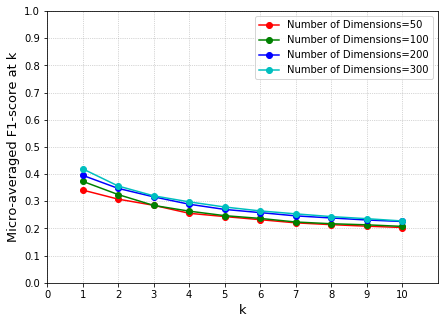

In [38]:
plt.clf()
ax = plt.gca()

ks = range(1, 11)

ax.plot(ks, feats_50, 'ro-', label='Number of Dimensions=50')

ax.plot(ks, feats_100, 'go-', label='Number of Dimensions=100')

ax.plot(ks, feats_200, 'bo-', label='Number of Dimensions=200')

ax.plot(ks, feats_300, 'co-', label='Number of Dimensions=300')

ax.set_xlim(0, 11)
ax.set_ylim(0, 0.5)
ax.set_xlabel('k', fontsize=13)

ax.set_ylabel('Micro-averaged F1-score at k', fontsize=13)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)
plt.gcf().set_size_inches(7,5)
ax.legend()
plt.show()

In [ ]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
plot_micro_f1_at_k(validation_scores,ax,train_scores)
plt.gcf().set_size_inches(7,5)
plt.show()